In [13]:
# Reference : https://github.com/erinnil/Sign-Language-MNIST-Neural-Network-Classifier.git
# Libraries 
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from collections import defaultdict
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)


In [14]:
# Load the training dataset
train_data = pd.read_csv('../archive/sign_mnist_train.csv')
# Load the testing dataset
test_data = pd.read_csv('../archive/sign_mnist_test.csv')
print("First five rows of the training dataset")
train_data.head()

First five rows of the training dataset


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [15]:
# Separate the data (features) and the classes
X_train = train_data.drop(["label"], axis=1)  # Features (all columns except the first one)
X_train = X_train / 255.0
y_train = train_data['label']   # Target (first column)

# Separate the data (features) and the classes
X_test = test_data.drop(['label'], axis=1)  # Features (all columns except the first one)
X_test = X_test / 255.0
y_test = test_data['label']   # Target (first column)

# Create validation dataset by splitting training data (10% for validation)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_validate.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

Training set size: 24709 samples
Validation set size: 2746 samples
Testing set size: 7172 samples


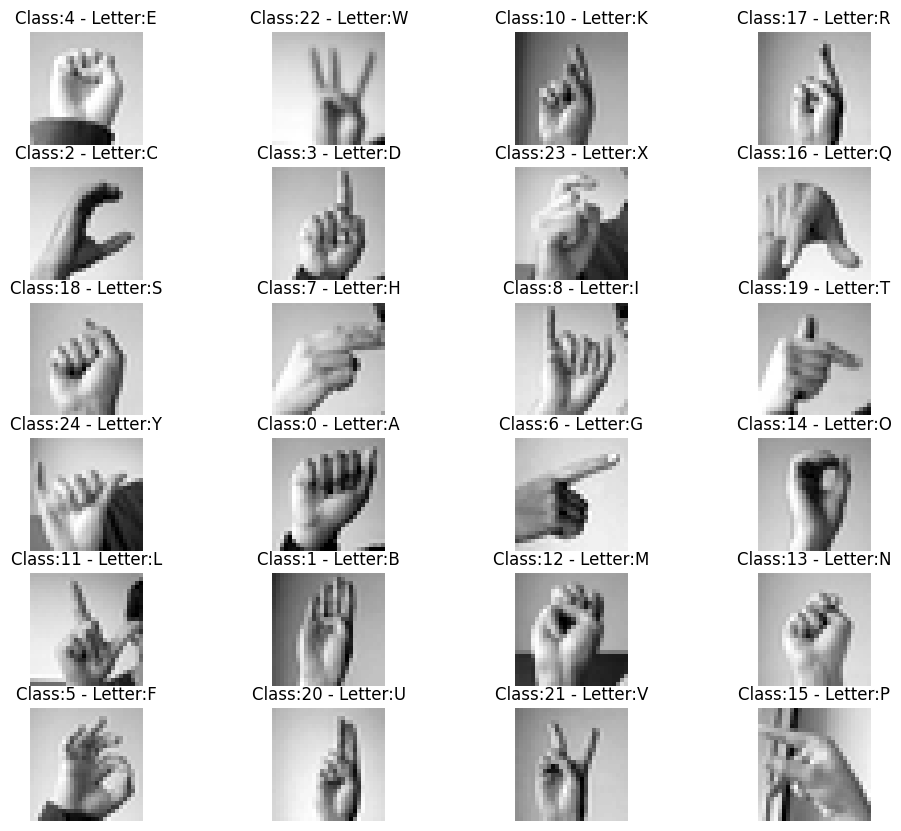

In [16]:

def show_image_by_condition( pixels, labels, label_condition=None, numbers=24, img_size=28):
    """
        Show images by label
    """
    label_to_letter = {i: chr(65 + i) for i in range(26)}

    pixels_tmp = pixels.reshape(-1, img_size, img_size, 1)
    plt.figure(figsize=(12, 12))

    cnt = 0
    if label_condition is None:
        label_condition_set = set(np.unique(labels))
    else:
        label_condition_set = set(label_condition)


    n_images = len(pixels)
    n_condition = len(label_condition_set)
    cached_label = set()
    while cnt < numbers:
        idx = np.random.randint(0, n_images)
        if labels[idx] in label_condition_set and (labels[idx] not in cached_label or cnt >= n_condition):
            cnt += 1
            cached_label.add(labels[idx])
            plt.subplot(numbers // 4 + 1, 4, cnt)
            plt.axis('off')
            plt.title(f"Class:{labels[idx]} - Letter:{label_to_letter[labels[idx]]}")
            plt.imshow(pixels_tmp[idx, :, :, 0], cmap='gray')

    plt.show()
    
show_image_by_condition(X_train.to_numpy(), y_train.to_numpy() , numbers=24)

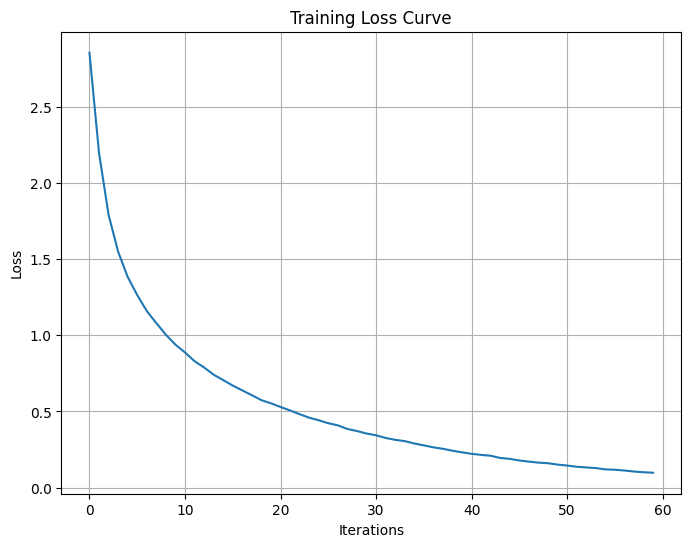

In [17]:
# Create neural network model
neural_net_model = MLPClassifier(
        hidden_layer_sizes=(64,),
        activation='relu',
        solver='adam',
        learning_rate_init=0.001,
        alpha= 0.0001,                 # ← regularization strength
        early_stopping=True,     # ← use internal validation for early stopping
        validation_fraction=0.1, # ← 10% of X_train used internally
        n_iter_no_change=10,     # ← patience for early stopping
        max_iter=60,
        random_state=42
    )

# Start the training
neural_net_model.fit(X_train, y_train)
plt.figure(figsize=(8,6))
plt.plot(neural_net_model.loss_curve_)
plt.title("Training Loss Curve")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid()
plt.show()


In [18]:
# Print the number of iterations the model ran before converging
print(f"Model converged in {neural_net_model.n_iter_} iterations.")


Model converged in 60 iterations.


In [19]:
# Determine model architecture 
layer_sizes = [neural_net_model.coefs_[0].shape[0]]  # Start with the input layer size
layer_sizes += [coef.shape[1] for coef in neural_net_model.coefs_]  # Add sizes of subsequent layers
layer_size_str = " x ".join(map(str, layer_sizes))
print(f"Training set size: {len(y_train)}")
print(f"Validation set size: {len(y_validate)}")
print(f"Test set size: {len(y_test)}")
print(f"Layer sizes: {layer_size_str}")

# Predict on all datasets
y_pred_validate = neural_net_model.predict(X_validate)
y_pred_test = neural_net_model.predict(X_test)

# Calculate accuracies
train_accuracy = neural_net_model.score(X_train, y_train)* 100
validate_accuracy = accuracy_score(y_pred_validate, y_validate)* 100
test_accuracy = accuracy_score(y_pred_test, y_test)* 100

print(f"----------")
print(f"Training Accuracy: {train_accuracy}%")
print(f"Validation Accuracy: {validate_accuracy}%")
print(f"Test Accuracy: {test_accuracy}%")

Training set size: 24709
Validation set size: 2746
Test set size: 7172
Layer sizes: 784 x 64 x 24
----------
Training Accuracy: 99.44149904892954%
Validation Accuracy: 99.2352512745812%
Test Accuracy: 70.287228109314%


In [20]:
# Create dictionaries to hold counts
correct_counts = defaultdict(int) # number of times the model predicted this class correctly
total_counts = defaultdict(int) # total number of test samples belonging to this class

# Count correct predictions and total predictions for each class
for true, pred in zip(y_test, y_pred_test):
    total_counts[true] += 1
    if true == pred:
        correct_counts[true] += 1 

# Calculate and print accuracy for each class
print(f"----------")
print("Per-class Test Accuracies:")
for class_id in sorted(total_counts.keys()):
    accuracy = correct_counts[class_id] / total_counts[class_id] * 100
    print(f"Class {class_id}: {accuracy:3.0f}%")

----------
Per-class Test Accuracies:
Class 0:  99%
Class 1:  90%
Class 2:  90%
Class 3:  84%
Class 4:  81%
Class 5:  91%
Class 6:  67%
Class 7:  81%
Class 8:  69%
Class 10:  53%
Class 11:  79%
Class 12:  70%
Class 13:  51%
Class 14:  62%
Class 15:  97%
Class 16:  76%
Class 17:  72%
Class 18:  39%
Class 19:  40%
Class 20:  40%
Class 21:  49%
Class 22:  61%
Class 23:  61%
Class 24:  55%


In [21]:
# Generate confusion matrix to find most misidentified classes
conf_matrix = confusion_matrix(y_test, y_pred_test)
class_labels = sorted(list(set(y_test))) # class labels are the unique values in y_test which are sorted so that they correspond to the confusion matrix rows/columns
print(class_labels)
# Calculate misidentification rates for each class
misidentification_rates = {}
for i, true_class in enumerate(class_labels):
    total_true = np.sum(conf_matrix[i, :]) # number of true instances for this class, sum of each element in the row
    correct = conf_matrix[i, i] # number of correct predictions for this class
    misidentified = total_true - correct
    misidentification_rate = (misidentified / total_true) * 100 if total_true > 0 else 0
    misidentification_rates[true_class] = misidentification_rate

# Find the 3 most misidentified classes
misidentified = sorted(misidentification_rates.items(), key=lambda x: x[1], reverse=True)
most_misidentified = misidentified[:3]
print(f"----------")
print("Most Misidentified Classes (letters):")
for class_id, rate in most_misidentified:
    print(f"Class {class_id}: {rate:.2f}% misidentification rate")


[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
----------
Most Misidentified Classes (letters):
Class 18: 60.98% misidentification rate
Class 20: 59.77% misidentification rate
Class 19: 59.68% misidentification rate


In [22]:

# Show what these misidentified classes are most often confused with
print(f"----------")
print("Common Misidentifications:")
for class_id, rate in most_misidentified:
    class_idx = class_labels.index(class_id)
    # Get the row for this class from confusion matrix
    row = conf_matrix[class_idx, :]
    # Set the correct prediction to 0 to find top misclassifications
    row_copy = row.copy()
    row_copy[class_idx] = 0
    # Find top 2 misclassifications
    top_mistakes = np.argsort(row_copy)[-2:][::-1]
    
    if row_copy[top_mistakes[0]] > 0:
        print(f"Class {class_id} most often confused with: ", end="")
        mistake_classes = []
        for mistake_idx in top_mistakes:
            if row_copy[mistake_idx] > 0:
                mistake_class = class_labels[mistake_idx]
                count = row_copy[mistake_idx]
                mistake_classes.append(f"Class {mistake_class} ({count} times)")
        print(", ".join(mistake_classes[:2]))



----------
Common Misidentifications:
Class 18 most often confused with: Class 8 (61 times), Class 12 (45 times)
Class 20 most often confused with: Class 17 (81 times), Class 10 (38 times)
Class 19 most often confused with: Class 23 (78 times), Class 8 (21 times)


Text(0.5, 192.72222222222217, 'Predicted label')

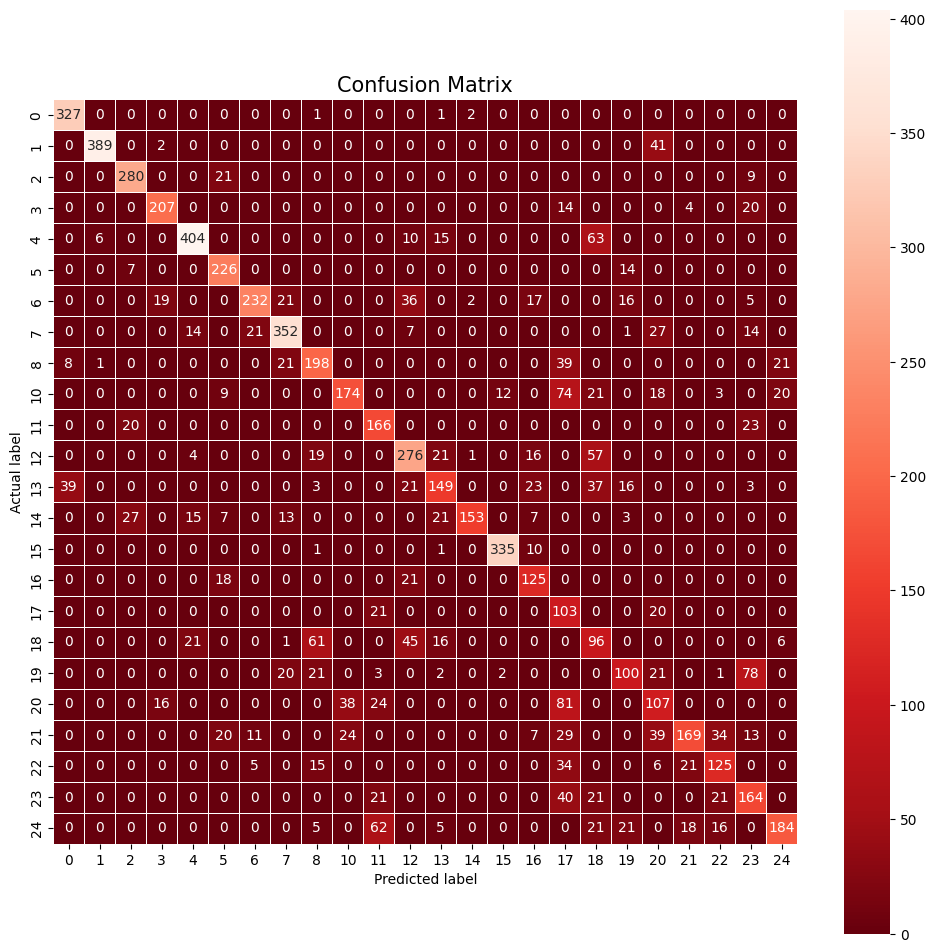

In [23]:
# Confusion matrix heatmap 
# Shows how often each class is predicted as each other class
plt.figure(figsize=(12,12))
sns.heatmap(conf_matrix, annot=True, 
            linewidths=.5, square = True, cmap = 'Reds_r', fmt='0.4g', xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix', size = 15)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [24]:
# Classification report for detailed precision, recall, f1-score
print("----------")
print("Classification Report:")
print(classification_report(y_test, y_pred_test))

# Precision -->	Of all samples the model predicted as class X, how many were correct?
# Recall -->	Of all samples that truly belong to class X, how many did the model identify correctly?
# F1-score -->	Harmonic mean of precision and recall, gives a balanced measure of model performance on class X 
# Support -->	Number of true instances for each class in the test set

# macro avg: average metrics across all classes, treating each class equally
# weighted avg: average metrics across all classes, weighted by number of instances per class

----------
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.99      0.93       331
           1       0.98      0.90      0.94       432
           2       0.84      0.90      0.87       310
           3       0.85      0.84      0.85       245
           4       0.88      0.81      0.85       498
           5       0.75      0.91      0.82       247
           6       0.86      0.67      0.75       348
           7       0.82      0.81      0.81       436
           8       0.61      0.69      0.65       288
          10       0.74      0.53      0.61       331
          11       0.56      0.79      0.66       209
          12       0.66      0.70      0.68       394
          13       0.65      0.51      0.57       291
          14       0.97      0.62      0.76       246
          15       0.96      0.97      0.96       347
          16       0.61      0.76      0.68       164
          17       0.25      0.72      0.37    